<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/prelim_PlatesCounter_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 平積み品の検数（予備実験）

## Class definition of PyTorch cosine and wavelet dictionary for sparse representation

In [ ]:
!pip -q install torch_dct

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.8 MB/s eta 0:00:00


In [ ]:
!pip -q install PyWavelets pytorch_wavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.6 MB/s eta 0:00:00


## DCT and Wavelet in PyTorch

In [ ]:
# load DCTWT1dTorch.py
!wget -q -N https://gist.githubusercontent.com/tsakai-g/ad5f430be47ff24220c7a4ecb7a29187/raw/7274c141305610a973ab14ef545c5f022d1ca9e2/DCTWT1dTorch.py
%run DCTWT1dTorch.py

## Sparse solvers and proximal mappings in PyTorch

In [ ]:
# load diffspm.py
!wget -q -N https://gist.githubusercontent.com/tsakai-g/ad5f430be47ff24220c7a4ecb7a29187/raw/7274c141305610a973ab14ef545c5f022d1ca9e2/diffspm.py
%run diffspm.py

## Demonstration of diffspm

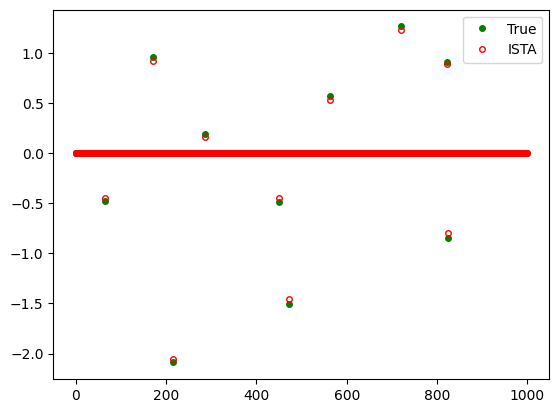

In [ ]:
# Usage
m, n = 300, 1000
matA = torch.randn(m, n)
fA = lambda x: matA @ x
fAT = lambda x: matA.T @ x
A = (fA, fAT)

import numpy as np
x_true = torch.zeros(n)
k = 10
T = np.random.choice(len(x_true), k, replace=False)
x_true[T] = torch.randn(k)
b = A[0](x_true)

L = LipEstimator(A, b)
hparam = {'lmd': 10, 'L': L, 'prox': lambda z,th: soft(z, th)}
#hparam = {'lmd': 100, 'L': L, 'prox': lambda z,th: scad(z, th)}


# layer_ista = lambda b, x: (b, step_ista(A, b, x, **hparam)[0])
# model = DeepUnfolding(layer_ista, maxiter=300)
# x0 = A[1](b)
# x_est = model(b, x0)[1]

layer_fista = lambda b, xwt: (b, step_fista(A, b, xwt, **hparam)[0])
model = DeepUnfolding(layer_fista, maxiter=100)
x0 = A[1](b)
xwt0 = (x0, x0.clone(), torch.tensor(1.))
x_est = model(b, xwt0)[1][0]


import matplotlib.pyplot as plt
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=4, mec='red', mew=1, label='ISTA')
plt.legend(loc='upper right', shadow=False)
plt.show()

## データの読み込み

In [ ]:
# prompt: next_fast_len相当のlambda関数
import math
next_fast_len = lambda n: 2**math.ceil(math.log2(n))

# prompt: dimで指定したindexにnで指定したサイズまでtorch.tensor x をゼロ埋め（zero padding）する関数 zero_padding
import torch
def pad(x, n, value=0, dim=-1):
  """
  Pads a tensor with zeros along a specified dimension.

  Args:
    x: The input tensor.
    dim: The dimension along which to pad.
    n: The size to pad to.

  Returns:
    The padded tensor.
  """

  pad_size = n - x.shape[dim]
  if pad_size <= 0:
    return x

  padding = [0, 0] * len(x.shape)
  padding[(2 * dim-1)%len(padding)] = pad_size
  padded_x = torch.nn.functional.pad(x, padding, mode='constant', value=value)
  return padded_x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
use_cuda: bool = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

import torchvision.io as io
from torchvision.transforms import functional as ttf

def bchw_from_center_crop(paths, hw=(1204,1204), dhw=(0,0), top_left=None, bottom_right=None):
    hw, dhw = torch.tensor(hw), torch.tensor(dhw)
    if hw.dim() == 1: hw = hw.expand(len(paths), -1)
    if dhw.dim() == 1: dhw = dhw.expand(len(paths), -1)
    images = []
    for b, path in enumerate(paths):
        img = io.read_image(path).expand(3,-1,-1).to(torch.float64) / 255
        h, w = img.shape[1], img.shape[2]
        if top_left is None:
            crop_top = int(((h - hw[b][0]) // 2) + dhw[b][0])
            crop_left = int(((w - hw[b][1]) // 2) + dhw[b][1])
            #print(crop_top, crop_left)
            img = ttf.crop(img, crop_top, crop_left, hw[b][0], hw[b][1])
            #img = ttf.center_crop(img, hw)
        else:
            crop_top, crop_left = top_left
            crop_bottom, crop_right = bottom_right
            img = ttf.crop(img, crop_top, crop_left, crop_bottom-crop_top, crop_right-crop_left)
        images.append(img)
    return torch.stack(images)

def rgb_to_gray(images):
    if images.shape[1] == 1: return images
    luminance_weights = torch.tensor([0.2989, 0.5870, 0.1140]).view(1, 3, 1, 1).to(images.device.type)
    return torch.sum(images * luminance_weights, dim=1, keepdim=True)
    #images.detach().cpu()


# prompt: next_fast_len相当のlambda関数
import math
next_fast_len = lambda n: 2**math.ceil(math.log2(n))

# prompt: dimで指定したindexにnで指定したサイズまでtorch.tensor x をゼロ埋め（zero padding）する関数 zero_padding
"""
    Pads a tensor with zeros along a specified dimension.
    Args:
        x: The input tensor.
        dim: The dimension along which to pad.
        n: The size to pad to.
      Returns:
        The padded tensor.
"""
def pad(x, n, value=0, dim=-1):
    pad_size = n - x.shape[dim]
    if pad_size <= 0:
        return x

    padding = [0, 0] * len(x.shape)
    padding[(2 * dim-1)%len(padding)] = pad_size
    padded_x = torch.nn.functional.pad(x, padding, mode='constant', value=value)
    return padded_x


import matplotlib.pyplot as plt
def gimshow(images, cmap='viridis', filename=None):   # (b, c, h, w)
    if images.shape[1] == 1: cmap = 'gray'
    if cmap == 'gray':
        images = rgb_to_gray(images.detach().cpu())
    image = images.permute(1,2,0,3).contiguous().view(images.shape[1], images.shape[2], -1)
    plt.imshow(image.detach().cpu().permute(1,2,0), cmap=cmap)
    plt.axis('off')  # Hide the axis
    if filename is not None:
        plt.savefig(filename + '.png', bbox_inches='tight', pad_inches=0.0, dpi=300)
    plt.show()


cpu


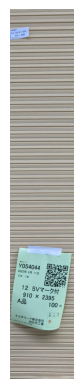

torch.Size([1, 1, 3467, 600])


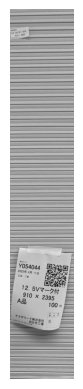

In [ ]:
# 読み込む画像の場所（変換前の画像，変換後の画像（写真））
filename = "20220413_SN_072_origin"
paths = [
#    "/content/drive/MyDrive/Sandbox/20220413_SN_052.jpg",
    "/content/drive/MyDrive/Sandbox/" + filename + ".jpg",  # 433.100-3900,100, 100 sheets
#    "/content/drive/MyDrive/indian_head/IMG_150cm_2.jpg"
    ]

# (h, w): 読み込みたい中央付近の領域の高さと幅
# (dh, dw): 位置の中央からのずれ
h, w, dh, dw = 1204+512, 1024, -256, 0
#images = bchw_from_center_crop(paths, hw=[h, w], dhw = [[0,0], [dh, dw]])

images = bchw_from_center_crop(paths, top_left=(433,0), bottom_right=(3900,600))

gimshow(images, filename=filename+'_crop')


# To estimate PSF with a single channel
is_color_psf = False
if not is_color_psf:
    images = rgb_to_gray(images)

print(images.shape)
gimshow(images, 'gray')

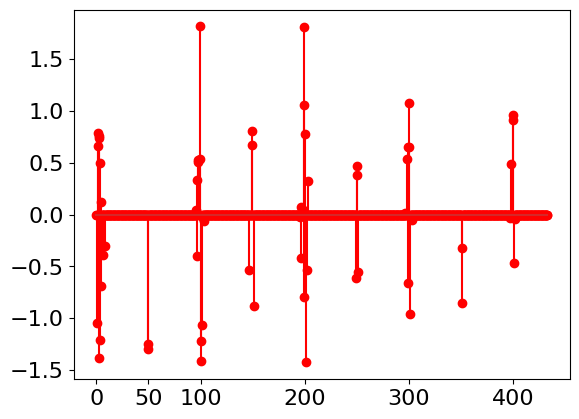

In [ ]:
import numpy as np
#b = torch.tensor(dat[1][np.newaxis, np.newaxis, :length], dtype=torch.float32).clone() # (N, C, L)
col = 100
bimg = images[0,0,:,col] - images[0,0,:,col].mean(dim=-1)
b = pad(bimg, next_fast_len(bimg.shape[-1]), dim=-1).to(torch.float32).unsqueeze(0).unsqueeze(0)
#plt.plot(b)

dic_DCTWT1d = {'norm': 'ortho', 'wavelet': 'db10', 'level': 3, 'mode': 'per', 'weight': 1, 'device': device}

dctwt = DCTWT1dTorch(**dic_DCTWT1d)      #.to(device)
idctwt = IDCTWT1dTorch(**dic_DCTWT1d)    #.to(device)

fA = lambda x: idctwt(x)
fAT = lambda y: dctwt(y)
A = (fA, fAT)

L = LipEstimator(A, b)
#hparam = {'lmd': 3e-1, 'L': L, 'prox': lambda z,th: soft(z, th)}
hparam = {'lmd': 3e-1, 'L': L, 'prox': lambda z,th: scad(z, th)}

# x0 = fAT(b)
# layer = lambda b, x: (b, step_ista(A, b, x, **hparam)[0])
# model = DeepUnfolding(layer, maxiter=3000).to(device)
# x_est = model(b, x0)[1]

layer = lambda b, xwt: (b, step_fista(A, b, xwt, **hparam)[0])
model = DeepUnfolding(layer, maxiter=30).to(device)
x0 = fAT(b)
xwt0 = (x0, x0.clone(), torch.tensor(1.))
x_est = model(b, xwt0)[1][0]

plt.tick_params(labelsize=16)
plt.stem(x_est[0,0,:b.shape[-1]//4], 'ro')
x_min, x_max = plt.xlim()
#xticks = plt.xticks()[0]
#plt.xticks(xticks, [f'{int(tick / 2)}' for tick in xticks])
plt.xlim(x_min, x_max)
plt.xticks(np.array([0,100,200,400,600,800]) / (bimg.shape[-1] / b.shape[-1]) )
#plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.gca().set_xticklabels([0,50,100,200,300,400])
#plt.gca().set_xticklabels([0,50,100,150,200,250,300,350,400,450,500])


plt.savefig(filename + '_crop_SparseFourierComponents.pdf', bbox_inches='tight', dpi=300)


In [ ]:
import numpy as np
#wave_nums = np.argsort(np.abs(x_est[0,0,:x_est.shape[-1]//16].numpy()))
x_est_c = x_est[0,0,:x_est.shape[-1]//16].numpy()
x_est_c[0:16] = 0
#print(x_est_c)
wave_nums = np.argsort(-np.abs(x_est_c)) / 2
for wave_num in wave_nums[:16]:
    print("wave number =", wave_num, "  ", wave_num * bimg.shape[-1] / b.shape[-1], "sheets")

wave number = 117.5    99.4561767578125 sheets
wave number = 236.0    199.7587890625 sheets
wave number = 237.5    201.0284423828125 sheets
wave number = 118.5    100.3026123046875 sheets
wave number = 59.0    49.939697265625 sheets
wave number = 58.5    49.5164794921875 sheets
wave number = 119.0    100.725830078125 sheets
wave number = 119.5    101.1490478515625 sheets
wave number = 235.5    199.3355712890625 sheets
wave number = 178.5    151.0887451171875 sheets
wave number = 176.5    149.3958740234375 sheets
wave number = 235.0    198.912353515625 sheets
wave number = 236.5    200.1820068359375 sheets
wave number = 177.0    149.819091796875 sheets
wave number = 117.0    99.032958984375 sheets
wave number = 239.0    202.298095703125 sheets


In [ ]:
import numpy as np
from scipy.stats import mode
from math import gcd
from functools import reduce

def estimate_x(a):
    a = np.sort(a)  # 昇順ソート
    diffs = np.diff(a)  # 隣接する要素の差分を計算

    # 閾値を設定して極端に小さい値を除外
    x_candidates = [d for d in diffs if d > 10]  # 10以上の差分のみ考慮
    if not x_candidates:
        return None  # 適切な候補がない場合は None を返す

    # GCD を計算
    x_gcd = reduce(gcd, x_candidates)

    # 最頻値を求める（ノイズに強い）
    x_mode = mode(x_candidates, keepdims=True).mode[0]

    # 最終的な x を決定（GCD が極端に小さい場合は最頻値を採用）
    return x_gcd if x_gcd > 10 else x_mode

x_est_c = x_est[0,0,:x_est.shape[-1]//16].numpy()
x_est_c[0:16] = 0
#print(x_est_c)
wave_nums = np.argsort(np.abs(x_est_c))

wn_best = estimate_x(wave_nums[-8:])
print("best wave number =", wn_best, "  ", wn_best * bimg.shape[-1] / b.shape[-1], "sheets")

for wave_num in wave_nums[-16:]:
    print("wave number =", wave_num, "  ", wave_num * bimg.shape[-1] / b.shape[-1], "sheets")

best wave number = 117    99.032958984375 sheets
wave number = 478    404.59619140625 sheets
wave number = 234    198.06591796875 sheets
wave number = 354    299.63818359375 sheets
wave number = 473    400.364013671875 sheets
wave number = 470    397.82470703125 sheets
wave number = 353    298.791748046875 sheets
wave number = 357    302.177490234375 sheets
wave number = 471    398.671142578125 sheets
wave number = 239    202.298095703125 sheets
wave number = 238    201.45166015625 sheets
wave number = 117    99.032958984375 sheets
wave number = 118    99.87939453125 sheets
wave number = 237    200.605224609375 sheets
wave number = 475    402.056884765625 sheets
wave number = 472    399.517578125 sheets
wave number = 235    198.912353515625 sheets


In [ ]:
import numpy as np
from scipy.stats import mode
from math import gcd
from functools import reduce

def estimate_x(a):
    a = np.sort(a)  # 昇順ソート

    # 差分を計算
    diffs = np.diff(a)

    # 大きめの間隔を優先的に考慮するため、適切な閾値を設定
    threshold = np.percentile(diffs, 75)  # 上位 25% の間隔を使用
    large_diffs = diffs[diffs >= threshold]

    # ヒストグラムを利用して間隔のピークを特定
    hist, bin_edges = np.histogram(large_diffs, bins=10)
    x_peak = bin_edges[np.argmax(hist)]  # 最も頻度の高い間隔

    # GCD を使った補正（小さい x の過大評価を防ぐ）
    x_gcd = reduce(gcd, large_diffs) if len(large_diffs) > 1 else x_peak

    # 最終的な x を決定（GCD が極端に小さい場合はヒストグラムのピーク値を採用）
    return max(x_gcd, x_peak) if x_gcd > 10 else x_peak

x_est_c = x_est[0,0,:x_est.shape[-1]//16].numpy()
x_est_c[0:16] = 0
#print(x_est_c)
wave_nums = np.argsort(np.abs(x_est_c))

wn_best = estimate_x(wave_nums[-8:])
print("best wave number =", wn_best, "  ", wn_best * bimg.shape[-1] / b.shape[-1], "sheets")

for wave_num in wave_nums[-16:]:
    print("wave number =", wave_num, "  ", wave_num * bimg.shape[-1] / b.shape[-1], "sheets")

best wave number = 117.0    99.032958984375 sheets
wave number = 478    404.59619140625 sheets
wave number = 234    198.06591796875 sheets
wave number = 354    299.63818359375 sheets
wave number = 473    400.364013671875 sheets
wave number = 470    397.82470703125 sheets
wave number = 353    298.791748046875 sheets
wave number = 357    302.177490234375 sheets
wave number = 471    398.671142578125 sheets
wave number = 239    202.298095703125 sheets
wave number = 238    201.45166015625 sheets
wave number = 117    99.032958984375 sheets
wave number = 118    99.87939453125 sheets
wave number = 237    200.605224609375 sheets
wave number = 475    402.056884765625 sheets
wave number = 472    399.517578125 sheets
wave number = 235    198.912353515625 sheets


In [ ]:
aaa = [13,14,28]
print(np.diff(aaa))

[ 1 14]


4096
torch.Size([1, 1, 4096])
torch.Size([1, 1, 4096])
torch.Size([1, 1, 4096])


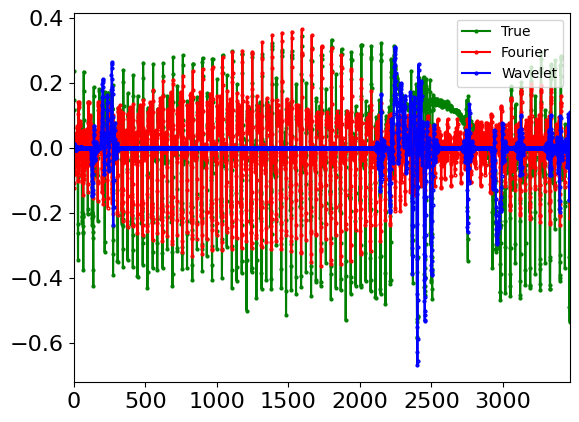

In [ ]:
bh = b.shape[-1]
print(bh)
br = fA(x_est).detach().cpu()
print(br.shape)
bc = idctwt.idct(x_est[..., :bh]).detach().cpu()
print(bc.shape)
bw = idctwt.idwt(x_est[..., bh:]) * dic_DCTWT1d['weight']
bw = bw.detach().cpu()
print(bw.shape)

import numpy as np
plt.tick_params(labelsize=16)
plt.plot(np.arange(bh), b[0,0], 'g.-', markersize=4, mec='green', label='True')
plt.plot(np.arange(bh), bc[0,0], 'ro-', mfc = 'None', markersize=2, mec='red', mew=1, label='Fourier')
plt.plot(np.arange(bh), bw[0,0], 'bo-', mfc = 'None', markersize=2, mec='blue', mew=1, label='Wavelet')
#plt.plot(np.arange(bh), bc[0,0], 'ro-', mfc = 'None', markersize=2, mec='red', mew=1, alpha=0)
#plt.plot(np.arange(bh), bw[0,0], 'bo-', mfc = 'None', markersize=2, mec='blue', mew=1, alpha=0)
plt.legend(loc='upper right', shadow=False)
plt.xlim(0,bimg.shape[-1])
#plt.show()

plt.tick_params(labelsize=16)
plt.savefig(filename + '_crop_Reconstruction.pdf', bbox_inches='tight', dpi=300)

4096
torch.Size([1, 1, 4096])
torch.Size([1, 1, 4096])
torch.Size([1, 1, 4096])


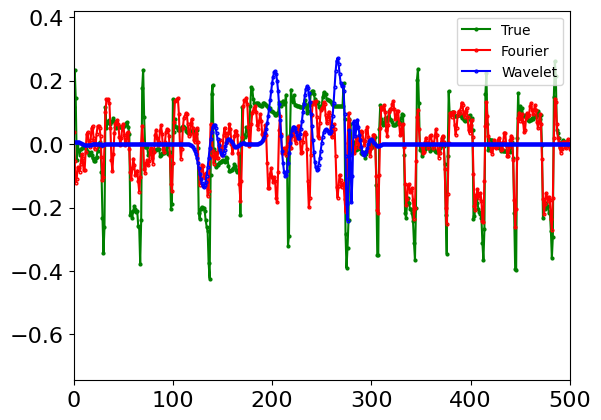

In [ ]:
bh = b.shape[-1]
print(bh)
br = fA(x_est).detach().cpu()
print(br.shape)
bc = idctwt.idct(x_est[..., :bh]).detach().cpu()
print(bc.shape)
bw = idctwt.idwt(x_est[..., bh:]) * dic_DCTWT1d['weight']
bw = bw.detach().cpu()
print(bw.shape)

import numpy as np
plt.tick_params(labelsize=16)
plt.plot(np.arange(bh), b[0,0], 'g.-', markersize=4, mec='green', label='True')
plt.plot(np.arange(bh), bc[0,0], 'ro-', mfc = 'None', markersize=2, mec='red', mew=1, label='Fourier')
plt.plot(np.arange(bh), bw[0,0], 'bo-', mfc = 'None', markersize=2, mec='blue', mew=1, label='Wavelet')
plt.legend(loc='upper right', shadow=False)

########
xlim = (0,500)
plt.xlim(xlim)
########

plt.tick_params(labelsize=16)
plt.savefig(filename + '_crop_'+ str(xlim[0]) + 'to' + str(xlim[1]) + '_Reconstruction.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# prompt: bimg をwavファイルに保存する

import scipy.io.wavfile as wavfile

# Assuming 'br' is your NumPy array containing the audio data
# and you have the sample rate (e.g., 44100 Hz)

sample_rate = 8000  # Replace with your actual sample rate if different

# Normalize the audio data to the range [-1, 1] if necessary
br = bimg.detach().cpu().numpy()
br_normalized = br / np.max(np.abs(br))

# Convert the data type to int16
br_int16 = (br_normalized * 32767).astype(np.int16)


wavfile.write("output.wav", sample_rate, br_int16)

In [ ]:
hoge = lambda *a, c=0, **b: print(a, c, b)
hoge(1,2,3, c=22, x=3, y=2)

puni = lambda *args: print(args, args[0]**2)
xx, bb = 3, 2.1
puni(xx, bb)

puni2 = lambda *args: args[0]**2
piyo = lambda b, x: (b, puni2(x))
print(piyo(bb, xx))

(1, 2, 3) 22 {'x': 3, 'y': 2}
(3, 2.1) 9
(2.1, 9)


In [ ]:
!nvidia-smi

Fri Nov 17 03:17:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |   7429MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------